### **Data Preparation**

In [2]:
# book = pd.read_parquet('/kaggle/input/hw1parquets/book.parquet')

In [3]:
# float_cols = book.select_dtypes(include='float').columns.tolist()
# book[float_cols]=book[float_cols].astype('float32')
# print(book.memory_usage(deep=True).sum() / 1024**2)
# book.head()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

trades = pd.read_parquet('/kaggle/input/hw1parquets/trades.parquet')

float_cols = trades.select_dtypes(include='float').columns.tolist()
trades[float_cols]=trades[float_cols].astype('float32')
print(trades.memory_usage(deep=True).sum() / 1024**2)
n = 10
# trades.head()

1920.5031433105469


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc

trades = pd.read_csv('/kaggle/input/hw1parquets/ticker.csv/ticker.csv')

float_cols = trades.select_dtypes(include='float').columns.tolist()
trades[float_cols]=trades[float_cols].astype('float32')
print(trades.memory_usage(deep=True).sum() / 1024**2)
n = 10

trades['price'] = (trades['bid_price'] + trades['ask_price']) / 2
trades['amount'] = trades['bid_amount'] + trades['ask_amount']
gc.collect()
trades.head()

1719.6361846923828


,local_ts,seq,remote_ts,remote_ts2,bid_price,bid_amount,ask_price,ask_amount,price,amount
0,1679443200002269696,2664656597671,1679443199998,1679443199993,28091.099609,0.885,28091.199219,17.243,28091.148438,18.128000
1,1679443200023076352,2664656597814,1679443200001,1679443199996,28091.099609,0.685,28091.199219,17.243,28091.148438,17.927999
2,1679443200025819392,2664656597962,1679443200003,1679443199999,28091.099609,0.685,28091.199219,17.223,28091.148438,17.907999
3,1679443200041581312,2664656598238,1679443200007,1679443200003,28091.099609,0.686,28091.199219,17.223,28091.148438,17.909000
4,1679443200045155072,2664656598743,1679443200015,1679443200010,28091.099609,0.686,28091.199219,16.635,28091.148438,17.321001


In [6]:
trades.head()

,local_ts,seq,remote_ts,remote_ts2,bid_price,bid_amount,ask_price,ask_amount,price,amount
0,1679443200002269696,2664656597671,1679443199998,1679443199993,28091.099609,0.885,28091.199219,17.243,28091.148438,18.128000
1,1679443200023076352,2664656597814,1679443200001,1679443199996,28091.099609,0.685,28091.199219,17.243,28091.148438,17.927999
2,1679443200025819392,2664656597962,1679443200003,1679443199999,28091.099609,0.685,28091.199219,17.223,28091.148438,17.907999
3,1679443200041581312,2664656598238,1679443200007,1679443200003,28091.099609,0.686,28091.199219,17.223,28091.148438,17.909000
4,1679443200045155072,2664656598743,1679443200015,1679443200010,28091.099609,0.686,28091.199219,16.635,28091.148438,17.321001


### **Features**

#### **Accumulation Distribution Line**

In [7]:
%%time
chunk_size = 25000000
trades['Low'] = 0.
trades['High'] = 0.

# for i in range(0, len(trades), chunk_size):
#     chunk = trades[['price', 'amount']].iloc[max(0, i-50):i+chunk_size]
#     rolling_chunk = chunk.rolling(n, min_periods=1, closed='right')
#     trades['Low'].iloc[i:i+chunk_size] = rolling_chunk['price'].min().iloc[-chunk_size:]
#     trades['High'].iloc[i:i+chunk_size] = rolling_chunk['price'].max().iloc[-chunk_size:]
#     BlockPeriodVolume = rolling_chunk['amount'].sum().iloc[-chunk_size:]  

rolling_chunk = trades.rolling(n, min_periods=1, closed='right')
trades['Low'] = rolling_chunk['price'].min()
trades['High'] = rolling_chunk['price'].max()
BlockPeriodVolume = rolling_chunk['amount'].sum()

MFV = (((trades['price'] - trades['Low']) - \
     (trades['High'] - trades['price'])) / (trades['High'] - trades['Low'] + 1e-20)) \
    * BlockPeriodVolume 

trades['ADL'] = 0.

for i in range(n):
#     indices = np.arange(i, len(MFV), n)
    trades['ADL'][i::10] = np.cumsum(MFV[i::10])
    
# trades['ADL'] = np.cumsum(MFV).shift(10) + MFV

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 4.39 s, sys: 1.98 s, total: 6.37 s
Wall time: 5.31 s


**Average Directional Index**

In [8]:
%%time
CLprev = trades['price'].shift(n)
trades['ADX'] = 0.0
ADX = np.zeros(len(trades))


DMP = pd.DataFrame((trades['High'] - trades['High'].shift(n)).values)
DMM = pd.DataFrame((trades['Low'].shift(n) - trades['Low']).values)

    
q1 = trades['High'] - trades['Low']
q2 = np.abs(trades['High'] - CLprev)
q3 = np.abs(trades['Low'] -  CLprev)

TrueRange = pd.DataFrame(np.vstack([q1, q2, q3]).max(axis=0))

TRI = pd.DataFrame(np.zeros(len(trades)))
DMPI = pd.DataFrame(np.zeros(len(trades)))
DMMI = pd.DataFrame(np.zeros(len(trades)))
for i in range(10):
    TRI[i::10] = TrueRange.iloc[i::10].rolling(14).mean() + 1e-6
    DMPI[i::10] = DMP.iloc[i::10].rolling(14).mean()
    DMMI[i::10] = DMM.iloc[i::10].rolling(14).mean()
    
DIP = (DMPI / TRI) * 100
DIM = (DMMI / -TRI) * 100

DX = ((np.abs(DIP - DIM) / (np.abs(DIP + DIM)+1e-5)) * 100)
# print(DX.isna().sum())

DX = pd.DataFrame(DX)

ADX = np.zeros(DX.shape)
for i in range(10):
    ADX[i::10] = DX.iloc[i::10].rolling(14).mean().values
    
    
# print(TRI.isna().sum())
# print(DMPI.isna().sum())
# print(DMMI.isna().sum())
# print(DIP.isna().sum())
# print(DIM.isna().sum())
# print(DX.isna().sum())
# print(trades['ADX'].isna().sum())


trades['ADX']=ADX

CPU times: user 11.7 s, sys: 13.4 s, total: 25.1 s
Wall time: 19.9 s


In [9]:
# trades['price'].ewm(alpha=1/14).mean()

**Change Momentum Oscillator**

In [10]:
Clp = trades['price'].diff(10) > 0
Cln = trades['price'].diff(10) < 0

In [11]:
Su = np.zeros(len(trades))
Sn = np.zeros(len(trades))
for i in range(10):
    Su[i::10]=(trades['price'].iloc[i::10] * Clp.iloc[i::10]).rolling(19).sum() 
    Sn[i::10]=(trades['price'].iloc[i::10]* Cln.iloc[i::10]).rolling(19).sum()

In [12]:
gc.collect()

159

In [13]:
# print(np.isnan(Su).sum())
# print(np.isnan(Sn).sum())
# print(np.isnan(Sn+Su).sum())
# print(np.isnan(Su-Sn).sum())
# print(Sn.shape, Su.shape)

In [14]:
CMO = 100 * (Su - Sn + 0.00001) / (Su + Sn + 0.00001)
print(np.isnan(CMO).sum())
CMO

180


array([ nan,  nan,  nan, ..., 100., 100., 100.])

In [15]:
CMO[[1000, 100000, 1000000, 10000000]]

array([ 60.00206255, 100.        , 100.        , 100.        ])

In [16]:
trades['CMO'] = CMO

**Momentum**

In [17]:
trades['MOM'] = trades['price'].diff(10)

**Rate of change**

In [18]:
trades['ROC'] = ((trades['price'].diff(120)) / trades['price'].shift(120))*100

**Stochastic Relative Strength Index**

In [19]:
CLd = trades['price'].diff(10)
CLdu = CLd.diff(10) > 0
CLdd = CLd.diff(10) < 0

AG = np.zeros(len(trades))
AL = np.zeros(len(trades))
for i in range(10):
    AG[i::10] = (CLdu.iloc[i::10] * CLd[i::10]).rolling(14).sum()
    AL[i::10] = (CLdd.iloc[i::10] * CLd[i::10]).rolling(14).sum()

RS = AG / (AL+1e-5)
RSI = pd.DataFrame(100 - (100 / (RS+1e-5)))

trades['StochRSI'] = 0.

for i in range(10):
    RSImin = RSI[i::10].rolling(10).min()
    RSImax = RSI[i::10].rolling(10).max()
    
    trades['StochRSI'][i::10] = ((RSI[i::10] - RSImin) / (RSImax - RSImin + 1e-4)).values.reshape((-1))

# trades['StochRSI'].head(1800).tail(20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Linear Regression Line**

In [20]:
%%time
linreg_window = 20
trades['c1'] = 0.
trades['c2'] = 0.
c2 = 1
c1 = trades['price'][0]

MBs = trades['price'].shift(10)
step = 5000
for i in range(step, len(trades), step):
    PV = c1 + c2*MBs.iloc[i-step:i]
#     print("PV:", PV.iloc[0])
    MB = MBs.iloc[i-step:i]
#     print("MB:", MB.iloc[0])
    PV_mean = PV.mean()
    MB_mean = MB.mean()
#     print("PVm, MBm: ", PV_mean, MB_mean)
    
    
    r = ((MB - MB_mean)*(PV-PV_mean)).sum() / np.sqrt(((MB-MB_mean)**2).sum() * ((PV-PV_mean)**2).sum()+1e-5)+1e-5
#     print("r: ", r)
    c2 = r * (PV.std() / MB.std()) + 1e-3
#     print("PV.std()",PV.std() ,"MB.std()", MB.std())
    c1 = PV_mean - c2* MB_mean + 1e-3
#     print("c1, c2:", c1, c2)
    
    
    trades['c1'].iloc[i-step:i]=c1
    trades['c2'].iloc[i-step:i]=c2
#     print("____")
    
    
# trades['c1'].head(15)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in float_scalars


CPU times: user 27.1 s, sys: 238 ms, total: 27.3 s
Wall time: 27.3 s


In [21]:
len(trades) / 1000000 * 0.836 / 60

0.5234199204666666

**Autocorrelation**

**Realized Volatility**

In [22]:
Rt = pd.DataFrame(np.log(trades['price']).diff(10))
trades['RealizedVol'] = 0
RealizedVol = 100* np.sqrt((Rt**2 + 1e-10).rolling(10).sum())
for i in range(10):
    patch = Rt.iloc[i::10]
    RV = 100* np.sqrt((patch**2 + 1e-10).rolling(10).sum())
    trades['RealizedVol'].iloc[i::10] = RV.values.reshape((-1))
# trades['RealizedVol']

**Realized Kernel**

In [23]:
def kernel(x):
    return 1-3*x**2+2*x**3

In [24]:
logdiff = pd.DataFrame(np.log(trades['price']).diff(10))
H = 16
n = 256
K = np.zeros((len(trades),1))
for h in range(-H,H+1,1):
    g_h = np.zeros((len(trades),1))
    k_w = kernel(h/H+1)
    for i in range(10):
        g_h[i::10] = (logdiff[i::10] * logdiff[i::10].shift(np.abs(h))).rolling(256).sum()
    K += k_w * g_h * 100

In [25]:
trades['RealizedKernel'] = K

**Jump Variation**

In [26]:
gc.collect()

46

In [27]:
r = np.log(trades['price'].diff(10))

BV = 3.14159 * 0.5 * (np.abs(r) * np.abs(r.shift(10)))
BV2 = np.zeros(len(trades))
JV = np.zeros(len(trades))
for i in range(10):
    BV2[i::10] = BV[i::10].rolling(10).sum()

JV = np.max(trades['RealizedVol'] - BV2, 0.)
trades['JumpVariation'] = JV

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [29]:
trades.head(10000).tail()

,local_ts,seq,remote_ts,remote_ts2,bid_price,bid_amount,ask_price,ask_amount,price,amount,...,ADX,CMO,MOM,ROC,StochRSI,c1,c2,RealizedVol,RealizedKernel,JumpVariation
9995,1679443249163705088,2664661312022,1679443249007,1679443248976,28094.199219,7.089,28094.300781,4.35,28094.25,11.439,...,7.142856,100.0,0.0,0.003198,0.0,28036.138351,1.001959,0.003162,9.834778e-07,-0.636526
9996,1679443249165573120,2664661312321,1679443249010,1679443248978,28094.199219,5.945,28094.300781,4.35,28094.25,10.295,...,7.142856,100.0,0.0,0.003198,0.0,28036.138351,1.001959,0.003162,9.816958e-07,-0.636526
9997,1679443249171709184,2664661312471,1679443249011,1679443248979,28094.199219,5.675,28094.300781,4.35,28094.25,10.025,...,7.142856,100.0,0.0,0.003198,0.0,28036.138351,1.001959,0.003162,9.535242e-07,-0.636526
9998,1679443249172200960,2664661312552,1679443249011,1679443248980,28094.199219,5.676,28094.300781,4.35,28094.25,10.026,...,7.142856,100.0,0.0,0.003198,0.0,28036.138351,1.001959,0.003162,9.535242e-07,-0.636526
9999,1679443249172564736,2664661312558,1679443249011,1679443248980,28094.199219,5.591,28094.300781,4.35,28094.25,9.941,...,7.142856,100.0,0.0,0.003198,0.0,28036.138351,1.001959,0.003162,9.599724e-07,-0.636526


In [30]:
trades.drop(columns=['price', 'amount','seq', 'remote_ts', 'bid_price', 'bid_amount', 'ask_price', 'ask_amount', 'amount'], inplace=True)

In [31]:
gc.collect()

3059

In [32]:
trades['remote_ts2'] = trades['remote_ts2'] * 1000000

In [33]:
trades.to_parquet('Hw2featuresNew.parquet')

In [20]:
# trades.drop(columns=['price', 'amount','seq', 'remote_ts', 'side'], inplace=True)
float_cols = trades.select_dtypes(include='float').columns.tolist()
trades[float_cols]=trades[float_cols].astype('float32')

In [21]:
trades.replace([np.inf, -np.inf], 0, inplace=True)
gc.collect()

105

In [22]:
trades.head(10000).tail(10)

,local_ts,remote_ts2,Low,High,ADL,ADX,CMO,MOM,ROC,StochRSI,c1,c2,RealizedVol,RealizedKernel,JumpVariation
9990,1679443374035708028,1679443374023,28086.199219,28086.500000,-59.778805,20.980404,76.472885,0.400391,0.021012,0.0,28034.105469,1.002029,0.007631,-0.000009,-0.003932
9991,1679443374035800576,1679443374023,28086.300781,28086.500000,-81.469620,10.703524,75.002563,0.300781,0.020296,0.0,28034.105469,1.002029,0.008003,-0.000009,-0.003932
9992,1679443374035801321,1679443374023,28086.300781,28086.500000,-124.639908,6.906253,75.002602,0.199219,0.020296,0.0,28034.105469,1.002029,0.007663,-0.000009,-0.003932
9993,1679443374035801859,1679443374023,28086.300781,28086.500000,-68.524200,7.032247,76.472977,0.199219,0.019941,0.0,28034.105469,1.002029,0.007455,-0.000009,-0.003932
9994,1679443374035802528,1679443374023,28086.300781,28086.500000,-68.453720,9.930785,75.002678,0.199219,0.019586,0.0,28034.105469,1.002029,0.007435,-0.000009,-0.003932
9995,1679443374035901952,1679443374023,28086.400391,28086.599609,-82.163513,16.133787,64.709145,0.298828,0.019586,0.0,28034.105469,1.002029,0.007576,-0.000009,-0.003932
9996,1679443374042885489,1679443374035,28086.400391,28086.599609,-69.681633,17.810072,73.336372,0.199219,0.019586,0.0,28034.105469,1.002029,0.007561,-0.000009,-0.003932
9997,1679443374143349760,1679443374135,28086.400391,28086.599609,-47.741169,16.859621,75.002724,0.099609,0.019231,0.0,28034.105469,1.002029,0.007514,-0.000009,-0.003932
9998,1679443374446048512,1679443374438,28086.500000,28086.599609,-69.074303,41.545673,75.002754,0.099609,0.019231,0.0,28034.105469,1.002029,0.007730,-0.000009,-0.003932
9999,1679443374674635520,1679443374666,28086.500000,28086.599609,-58.550415,53.692627,86.668114,0.000000,0.019586,0.0,28034.105469,1.002029,0.007397,-0.000009,-0.003932


In [34]:
trades.dropna(inplace=True)

In [35]:
# trades.to_parquet("Hw2features.parquet")

In [36]:
# trades[trades.columns[5:].values] = trades[trades.columns[5:].values].astype('float16')

In [37]:
import gc
gc.collect()

105

**Train**

**Load Hw1 Features**

In [28]:
import pandas as pd
import numpy as np
import gc
tf = pd.read_parquet('/kaggle/input/hw1parquets/tradeFeatures.parquet')


tf.rename(columns={"local_ts_x": "local_ts"}, inplace=True)
good_cols = ['local_ts', 'PastRet100ms_x',
'PastRet250ms_x', 'PastRet500ms_x', 'PastRet1000ms_x', 'PastRet2000ms_x',
'PastRet250ms_y', 'PastRet500ms_y', 'PastRet1000ms_y', 'PastRet2000ms_y',
'Div5S', 'Div9S', 'Div19S', 'Div38S', 'Div75S', 'Div150S', 'Div300S', 'Div600S'
]
tf = tf[good_cols]
gc.collect()

float_cols = tf.select_dtypes(include='float').columns.tolist()
tf[float_cols]=tf[float_cols].astype('float32')

In [39]:
tf = pd.merge_asof(trades, tf, right_on='local_ts', left_on='remote_ts2')
del trades
gc.collect()

23

In [40]:
# tf.head(300).tail(15)

In [29]:
import gc
import pandas as pd
ob = pd.read_parquet('/kaggle/input/hw1parquets/ob_features.parquet')
print(len(tf), len(ob))

ob_f = ['timestamp', '100msTradeImb_x',
       '250msTradeImb_x', '500msTradeImb_x', '1000msTradeImb_x',
       '2000msTradeImb_x',
        '100msTradeImb_y',
       '250msTradeImb_y', '500msTradeImb_y', '1000msTradeImb_y',
       '2000msTradeImb_y']
ob = ob[ob_f]

ob_float_cols = ob.select_dtypes(include='float').columns.tolist()
ob[ob_float_cols]=ob[ob_float_cols].astype('float32')
gc.collect()


target = pd.read_parquet('/kaggle/input/hw1parquets/target.parquet')
target['target'] = target['target'].astype('int8')

tob = pd.merge_asof(ob, tf, right_on='local_ts', left_on='timestamp')
del ob
gc.collect()

5760692 6403491


0

In [30]:
tob.drop(columns=['timestamp'], inplace=True)

In [31]:
end_mem = tob.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))

Memory usage after optimization is: 757.25 MB


In [44]:
len(tob)

20546192

In [32]:
final = pd.merge_asof(target,tob, on='local_ts')

In [33]:
end_mem = final.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))

Memory usage after optimization is: 4478.17 MB


In [35]:
final.head(1000).tail(15)

,local_ts,target,100msTradeImb_x,250msTradeImb_x,500msTradeImb_x,1000msTradeImb_x,2000msTradeImb_x,100msTradeImb_y,250msTradeImb_y,500msTradeImb_y,...,PastRet1000ms_y,PastRet2000ms_y,Div5S,Div9S,Div19S,Div38S,Div75S,Div150S,Div300S,Div600S
985,1679443210826032384,-1,4.928994,46.238998,98.539993,545.398010,212.047943,-0.12671,0.11981,1.57320,...,1.495033,2.095967,-1.699692,-1.763351,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029
986,1679443210827636992,-1,4.928994,46.238998,98.539993,545.398010,212.047943,-0.12671,0.11981,1.57320,...,1.495033,2.095967,-1.699692,-1.763351,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029
987,1679443210828105216,-1,4.928994,46.238998,98.539993,545.398010,212.047943,-0.12671,0.11981,1.57320,...,1.495033,2.095967,-1.699692,-1.763351,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029,-1.767029
988,1679443210830896128,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
989,1679443210830896802,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
990,1679443210836186880,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
991,1679443210836680960,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
992,1679443210837293824,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
993,1679443210839071488,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500
994,1679443210841070592,-1,-6.767008,26.008995,60.037991,541.130005,294.373932,-0.34052,-0.33543,0.27227,...,1.784863,1.639504,-2.647134,-2.710795,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500,-2.714500


In [36]:
del tob
del tf
gc.collect()

1847

In [37]:
final.dropna(inplace=True)

In [49]:
# final.to_parquet('final1.parquet')

In [50]:
# final.drop(columns=['timestamp'], inplace=True)
# gc.collect()

In [14]:
gc.collect()

59

In [38]:
final.drop(columns=['local_ts'], inplace=True)
gc.collect()

46

In [53]:
final.dtypes

target                 int8
Low                 float32
High                float32
ADL                 float32
ADX                 float32
CMO                 float32
MOM                 float32
ROC                 float32
StochRSI            float32
c1                  float32
c2                  float32
RealizedVol         float32
RealizedKernel      float32
JumpVariation       float32
PastRet100ms_x      float32
PastRet250ms_x      float32
PastRet500ms_x      float32
PastRet1000ms_x     float32
PastRet2000ms_x     float32
PastRet250ms_y      float32
PastRet500ms_y      float32
PastRet1000ms_y     float32
PastRet2000ms_y     float32
Div5S               float32
Div9S               float32
Div19S              float32
Div38S              float32
Div75S              float32
Div150S             float32
Div300S             float32
Div600S             float32
100msTradeImb_x     float32
250msTradeImb_x     float32
500msTradeImb_x     float32
1000msTradeImb_x    float32
2000msTradeImb_x    

In [16]:
float_cols = final.select_dtypes(include='float').columns.tolist()
final[float_cols]=final[float_cols].astype('float16')
gc.collect()

23

In [55]:
end_mem = final.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))

Memory usage after optimization is: 6054.48 MB


In [2]:
import pandas as pd
import numpy as np
import gc

final = pd.read_parquet('/kaggle/input/hw1parquets/final1.parquet')
final.dropna(inplace=True)
float_cols = final.select_dtypes(include='float').columns.tolist()
final[float_cols]=final[float_cols].astype('float16')
gc.collect()
end_mem = final.memory_usage().sum() / 1024**2
print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))


Memory usage after optimization is: 6340.03 MB


In [45]:
final.columns[2:]

Index(['Low', 'High', 'ADL', 'ADX', 'CMO', 'MOM', 'ROC', 'StochRSI', 'c1',
       'c2', 'RealizedVol', 'RealizedKernel', 'JumpVariation',
       'PastRet100ms_x', 'PastRet250ms_x', 'PastRet500ms_x', 'PastRet1000ms_x',
       'PastRet2000ms_x', 'PastRet250ms_y', 'PastRet500ms_y',
       'PastRet1000ms_y', 'PastRet2000ms_y', 'Div5S', 'Div9S', 'Div19S',
       'Div38S', 'Div75S', 'Div150S', 'Div300S', 'Div600S', '100msTradeImb_x',
       '250msTradeImb_x', '500msTradeImb_x', '1000msTradeImb_x',
       '2000msTradeImb_x', '100msTradeImb_y', '250msTradeImb_y',
       '500msTradeImb_y', '1000msTradeImb_y', '2000msTradeImb_y'],
      dtype='object')

In [3]:
y = final['target'].to_numpy()
final.drop(columns=['target'], inplace=True)

# final.drop(columns=['RealizedKernel'], inplace=True)

gc.collect()

23

In [19]:
final.drop(columns=['JumpVariation'], inplace=True)

In [ ]:
final = final.to_numpy()
gc.collect()

In [4]:
# final[:, 0] = 0

In [ ]:
gc.collect()

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()
scaler = StandardScaler(copy=False)

X_train, X_test, y_train, y_test = train_test_split(final, y, test_size=0.5, random_state=42, shuffle=False)
l = len(final)
del final
del y

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42, shuffle=False)


print(len(X_train) , len(X_val) , len(X_test) )

18779682 7511873 11267810


In [22]:
gc.collect()

23

In [5]:
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [12]:
# Define parameters for LightGBM model
import lightgbm as lgb
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'num_leaves': 15,
    'learning_rate': 0.15,
    'min_data_in_leaf': 100000,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.01,
    'lambda_l2': 0.01,
}

# Create LightGBM datasets
lgb_target = y_train + 1
print(lgb_target[[10,20,30,50,10000,100000]])
train_dataset = lgb.Dataset(X_train, lgb_target)
valid_dataset = lgb.Dataset(X_val, y_val+1)

# Train LightGBM model
model = lgb.train(params=params,
                  train_set=train_dataset,
                  valid_sets=[valid_dataset],
                  num_boost_round=150,
                  early_stopping_rounds=5)

train_predictions = np.argmax(model.predict(X_train), axis=1) - 1
val_predictions = np.argmax(model.predict(X_val), axis=1) - 1
test_predictions = np.argmax(model.predict(X_test), axis=1) - 1

print(metric(y_train, train_predictions))
print(metric(y_val, val_predictions))
print(metric(y_test, test_predictions))

[1 1 1 1 1 1]


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 6.388189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10198
[LightGBM] [Info] Number of data points in the train set: 18779682, number of used features: 40
[LightGBM] [Info] Start training from score -1.355442
[LightGBM] [Info] Start training from score -0.720463
[LightGBM] [Info] Start training from score -1.363987
[1]	valid_0's multi_logloss: 1.05032
Training until validation scores don't improve for 5 rounds
[2]	valid_0's multi_logloss: 1.04705
[3]	valid_0's multi_logloss: 1.03953
[4]	valid_0's multi_logloss: 1.03748
[5]	valid_0's multi_logloss: 1.03611
[6]	valid_0's multi_logloss: 1.03478
[7]	valid_0's multi_logloss: 1.03201
[8]	valid_0's multi_logloss: 1.02923
[9]	valid_0's multi_logloss: 1.02606
[10]	valid_0's multi_logloss: 1.02244
[11]	valid_0's multi_logloss: 1.01946
[12]	valid_0's multi_logloss: 1.01389
[13]	valid_0's multi_logloss: 1.010

In [14]:
model.feature_importance()

array([180, 171, 172,   7,  17,  27,  19,  24,   0, 253, 175,  96, 105,
         0,  36,  33,  30,  16,  58,  39,  13,  25,  93,  17,  26,  23,
        31,  38,  31,  30,  47, 102,  24,  10,  10,  23,   5,  12,   6,
        16,  60], dtype=int32)

In [15]:
model = LogisticRegression(penalty='l2',max_iter=25, C=0.001)

In [16]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=0.001, max_iter=25)

In [17]:
features = ['Low', 'High', 'ADL', 'ADX', 'CMO', 'MOM', 'ROC', 'StochRSI', 'c1',
       'c2', 'RealizedVol', 
            'RealizedKernel',
            'JumpVariation',
       'PastRet100ms_x', 'PastRet250ms_x', 'PastRet500ms_x', 'PastRet1000ms_x',
       'PastRet2000ms_x', 'PastRet250ms_y', 'PastRet500ms_y',
       'PastRet1000ms_y', 'PastRet2000ms_y', 'Div5S', 'Div9S', 'Div19S',
       'Div38S', 'Div75S', 'Div150S', 'Div300S', 'Div600S', '100msTradeImb_x',
       '250msTradeImb_x', '500msTradeImb_x', '1000msTradeImb_x',
       '2000msTradeImb_x', '100msTradeImb_y', '250msTradeImb_y',
       '500msTradeImb_y', '1000msTradeImb_y', '2000msTradeImb_y']

In [18]:
column_names = features
coefficients = model.coef_

# create a dictionary with column names and coefficients for each class
feature_importances = {}
for i, class_label in enumerate(model.classes_):
    class_coefficients = coefficients[i]
    class_feature_importances = dict(zip(column_names, class_coefficients))
    feature_importances[class_label] = class_feature_importances

# print the feature importances for each class
for class_label, class_feature_importances in feature_importances.items():
    print(f"Class {class_label}:")
    sorted_class_feature_importances = sorted(class_feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)
    for feature, importance in sorted_class_feature_importances:
        print(f"\t{feature}: {importance:.4f}")

Class -1:
	RealizedKernel: 0.4647
	Low: -0.3038
	c2: -0.2983
	250msTradeImb_x: -0.2460
	RealizedVol: 0.2062
	ADL: 0.1376
	High: 0.1359
	Div600S: -0.1094
	Div75S: 0.0970
	Div38S: -0.0867
	MOM: -0.0697
	500msTradeImb_y: -0.0653
	ADX: -0.0553
	500msTradeImb_x: 0.0533
	1000msTradeImb_x: 0.0521
	1000msTradeImb_y: 0.0459
	100msTradeImb_x: 0.0453
	Div5S: 0.0373
	250msTradeImb_y: -0.0334
	PastRet2000ms_y: -0.0316
	2000msTradeImb_x: -0.0313
	JumpVariation: 0.0274
	Div19S: 0.0220
	PastRet500ms_y: -0.0218
	PastRet1000ms_x: 0.0213
	2000msTradeImb_y: 0.0206
	PastRet2000ms_x: 0.0201
	Div9S: 0.0183
	PastRet1000ms_y: -0.0154
	100msTradeImb_y: 0.0149
	PastRet250ms_y: -0.0143
	Div150S: 0.0118
	ROC: -0.0099
	StochRSI: 0.0098
	Div300S: -0.0066
	PastRet250ms_x: -0.0043
	CMO: -0.0033
	c1: -0.0006
	PastRet500ms_x: -0.0004
	PastRet100ms_x: 0.0000
Class 0:
	RealizedKernel: -0.9147
	c2: 0.3637
	Low: 0.2952
	ADL: -0.2153
	High: -0.2115
	RealizedVol: -0.2004
	ADX: 0.1543
	Div38S: 0.1466
	100msTradeImb_x: 0.1002
	

In [19]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

In [21]:
res_train = metric(y_train, y_pred_train)
res_val = metric(y_val, y_pred_val)
res_test = metric(y_test, y_pred_test)
print(res_train, res_val, res_test)

159.8872140741013 -12.873691134817756 8.808314939386028


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  from ipykernel import kernelapp as app


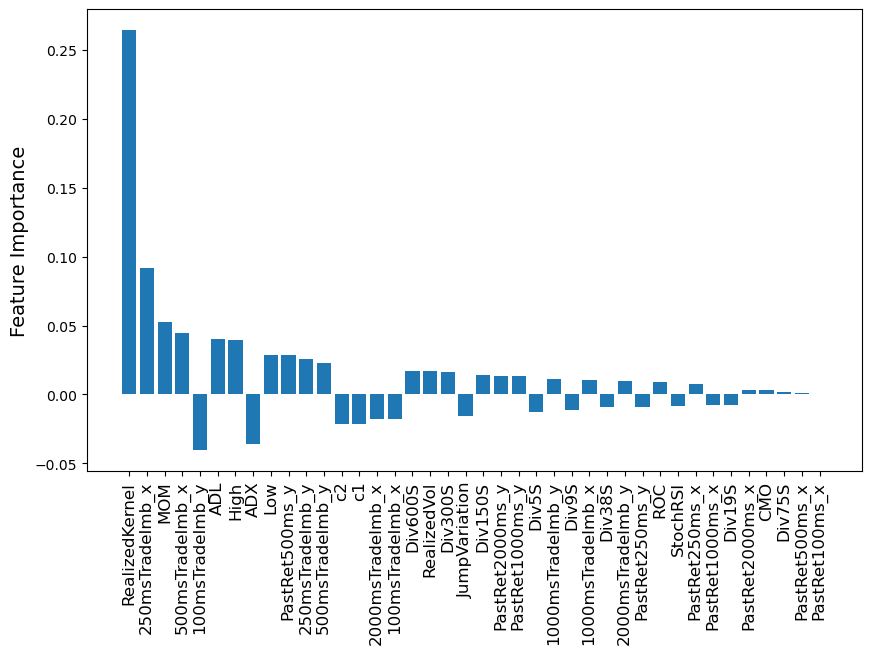

In [13]:
# get the feature names and coefficients
import matplotlib.pyplot as plt
feature_names = features
coefficients = model.coef_[2]

# create a dictionary with feature names and coefficients
feature_importances = dict(zip(feature_names, coefficients))

# sort the dictionary by absolute value of coefficients
sorted_feature_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# create bar plot of feature importances
fig, ax = plt.subplots(figsize=(10,6))
ax.bar([f[0] for f in sorted_feature_importances], [f[1] for f in sorted_feature_importances])
ax.set_xticklabels([f[0] for f in sorted_feature_importances], rotation=90, fontsize=12)
ax.set_ylabel('Feature Importance', fontsize=14)
plt.show()

In [53]:
res_train = metric(y_train, y_pred_train)
res_val = metric(y_val, y_pred_val)
res_test = metric(y_test, y_pred_test)
print(res_train, res_val, res_test)

183.3622549019298 94.91243918062598 104.29051195762887 100.53928284682772


In [3]:
import pandas as pd
import numpy as np
tf = pd.read_parquet('/kaggle/input/hw1parquets/tradeFeatures.parquet')
import gc
tf.rename(columns={"local_ts_x": "local_ts"}, inplace=True)
good_cols = ['local_ts', 'PastRet100ms_x',
'PastRet250ms_x', 'PastRet500ms_x', 'PastRet1000ms_x', 'PastRet2000ms_x',
'PastRet250ms_y', 'PastRet500ms_y', 'PastRet1000ms_y', 'PastRet2000ms_y',
'Div5S', 'Div9S', 'Div19S', 'Div38S', 'Div75S', 'Div150S', 'Div300S', 'Div600S'
]
tf = tf[good_cols]
gc.collect()
float_cols = tf.select_dtypes(include='float').columns.tolist()
tf[float_cols]=tf[float_cols].astype('float16')
ob = pd.read_parquet('/kaggle/input/hw1parquets/ob_features.parquet')
ob_f = ['timestamp', '100msTradeImb_x',
       '250msTradeImb_x', '500msTradeImb_x', '1000msTradeImb_x',
       '2000msTradeImb_x',
        '100msTradeImb_y',
       '250msTradeImb_y', '500msTradeImb_y', '1000msTradeImb_y',
       '2000msTradeImb_y']
ob = ob[ob_f]
gc.collect()
print(len(ob))
ob.dropna(inplace=True)
tf.dropna(inplace=True)
print(len(ob))
target = pd.read_parquet('/kaggle/input/hw1parquets/target.parquet')
target['target'] = target['target'].astype('int8')
ob_float_cols = ob.select_dtypes(include='float').columns.tolist()
ob[ob_float_cols]=ob[ob_float_cols].astype('float16')
n = pd.merge_asof(target, ob, left_on='local_ts', right_on='timestamp')
n.dropna(inplace=True)
del ob
del target
gc.collect()

final = pd.merge_asof(n, tf, on='local_ts')
del n
del tf
gc.collect()
final.drop(columns=['local_ts', 'timestamp'], inplace=True)

from sklearn.model_selection import train_test_split
y = final['target']
X = final.drop(columns=['target'])

del final
gc.collect()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=False)

from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

import numpy as np
from sklearn.metrics import confusion_matrix

def metric(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    weight_matrix = np.array([
        [1.9,     0,    -2],
        [-0.3,    0,    -0.3],
        [-2,      0,     1.9]
    ])
    
    hit_matrix = conf_matrix * weight_matrix
    hit_matrix_sum = np.sum(hit_matrix)
    action_count = np.sum(conf_matrix[:, 0]) + np.sum(conf_matrix[:, 2])
    if action_count == 0:
        return 0
    else:
        return hit_matrix_sum / np.sqrt(action_count)

res = metric(y_pred, y_test)
print(res)

6403491
6403489


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


442.0510429593468


In [ ]:
res = metric(y_test, y_pred)
print(res)

In [ ]:
import lightgbm as lgb

In [ ]:
# Define parameters for LightGBM model
import lightgbm as lgb
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'num_leaves': 21,
    'learning_rate': 0.05,
    'min_data_in_leaf': 2500,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
}

# Create LightGBM datasets
lgb_target = y_train + 1
print(lgb_target[[10,20,30,50,10000,100000]])
train_dataset = lgb.Dataset(X_train, lgb_target)
valid_dataset = lgb.Dataset(X_val, y_val+1)

# Train LightGBM model
model = lgb.train(params=params,
                  train_set=train_dataset,
                  valid_sets=[valid_dataset],
                  num_boost_round=150,
                  early_stopping_rounds=5,
                  feval=metric)

train_predictions = np.argmax(model.predict(X_train), axis=1) - 1
val_predictions = np.argmax(model.predict(X_val), axis=1) - 1
test_predictions = np.argmax(model.predict(X_test), axis=1) - 1

print(metric(y_train, train_predictions))
print(metric(y_val, val_predictions))
print(metric(y_test, test_predictions))

In [ ]:
train_predictions = np.argmax(model.predict(X_train), axis=1) - 1
val_predictions = np.argmax(model.predict(X_val), axis=1) - 1
test_predictions = np.argmax(model.predict(X_test), axis=1) - 1

In [ ]:
print(metric(y_train, train_predictions))
print(metric(y_val, val_predictions))
print(metric(y_test, test_predictions))